# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Random-Acts-of-Pizza" data-toc-modified-id="Random-Acts-of-Pizza-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Random Acts of Pizza</a></div><div class="lev1 toc-item"><a href="#Continuous-Features" data-toc-modified-id="Continuous-Features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Continuous Features</a></div><div class="lev2 toc-item"><a href="#Heatmap-for-presentation" data-toc-modified-id="Heatmap-for-presentation-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Heatmap for presentation</a></div><div class="lev1 toc-item"><a href="#Text-Features" data-toc-modified-id="Text-Features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Text Features</a></div><div class="lev1 toc-item"><a href="#Training-a-predictor" data-toc-modified-id="Training-a-predictor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training a predictor</a></div><div class="lev1 toc-item"><a href="#Adding-features-together" data-toc-modified-id="Adding-features-together-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Adding features together</a></div><div class="lev1 toc-item"><a href="#Future-recommendations" data-toc-modified-id="Future-recommendations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Future recommendations</a></div><div class="lev1 toc-item"><a href="#For-Fun" data-toc-modified-id="For-Fun-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>For Fun</a></div>

# Random Acts of Pizza

The following notebook details an analysis performed on the "Random Acts of Pizza" dataset originally presented in the paper [How to Ask for a Favor: A Case Study on the Success of Altruistic Requests](http://cs.stanford.edu/~althoff/raop-dataset/altruistic_requests_icwsm.pdf) ('Altruistic Requests'). This analysis has been done as part of a case presentation for a Hootsuite job interview. Stay _hootiful_ you guys.

First we'll import necessary libraries and data.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Allows the use of display() for DataFrames

import unicodedata
import sys

from sklearn import grid_search, cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import scipy as scipy

import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Size for all figures generated for consistency.
FIG_SIZE = (14,8)


path = './pizza_request_dataset.json'
df = pd.io.json.read_json(path)


/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tyler/anaconda2/envs/sdc/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


First lets have a look at an example and get an idea of how many posts are successful.

In [4]:
print('Example Datapoint:\n')
ri = random.randint(0, len(df))
print(df.iloc[ri])

got_pizza = df['requester_received_pizza'].value_counts()

print('\nCounts for sucessfull pizza aquisition:\n', got_pizza)
print('The average success rate is: %.3f%%' %(got_pizza[1]/(sum(got_pizza))))


Example Datapoint:

giver_username_if_known                                                                who_is_kaiser_soze
in_test_set                                                                                          True
number_of_downvotes_of_request_at_retrieval                                                            10
number_of_upvotes_of_request_at_retrieval                                                              10
post_was_edited                                                                                         0
request_id                                                                                       t3_xzsu3
request_number_of_comments_at_retrieval                                                                 5
request_text                                            Hello /RAOP! I've been a Redditor for quite so...
request_text_edit_aware                                 Hello /RAOP! I've been a Redditor for quite so...
request_title             

Of the attributes the following are deemed to be of interest:

In [5]:
cont_features = ['number_of_downvotes_of_request_at_retrieval',
                 'number_of_upvotes_of_request_at_retrieval',
                 'request_number_of_comments_at_retrieval',
                 'requester_account_age_in_days_at_request',
                 'requester_account_age_in_days_at_retrieval',
                 'requester_days_since_first_post_on_raop_at_request',
                 'requester_days_since_first_post_on_raop_at_retrieval',
                 'requester_number_of_comments_at_request',
                 'requester_number_of_comments_at_retrieval',
                 'requester_number_of_comments_in_raop_at_request',
                 'requester_number_of_comments_in_raop_at_retrieval',
                 'requester_number_of_posts_at_request',
                 'requester_number_of_posts_at_retrieval',
                 'requester_number_of_posts_on_raop_at_request',
                 'requester_number_of_posts_on_raop_at_retrieval',
                 'requester_number_of_subreddits_at_request',
                 'requester_upvotes_minus_downvotes_at_request',
                 'requester_upvotes_minus_downvotes_at_retrieval',
                 'requester_upvotes_plus_downvotes_at_request',
                 'requester_upvotes_plus_downvotes_at_retrieval']
                
text_features = ['request_title',
                 'request_text_edit_aware',
                 'request_text']

time_features_names = ['unix_timestamp_of_request',
                 'unix_timestamp_of_request_utc']
    
bool_features = None

target = 'requester_received_pizza'

Next let's have a look at a sample of the text:

In [6]:
ri = random.randint(0, len(df))

print('Datapoint index:', ri)
for feature in text_features:
    print('\n'+ feature + ':')
    print(df.iloc[ri][feature])
    
print('\nReceived Pizza:',df.iloc[ri]['requester_received_pizza'])

Datapoint index: 1144

request_title:
[Request] Starving musicians together before this hurricane, would love a pizza. 

request_text_edit_aware:


request_text:


Received Pizza: False


The following are points of interest to show both people who received pizza and people who did not.
```
true_poi = [1808, 4356, 228, 1838]
false_poi = [3497, 981, 2520, 5396]

```


As the continuous fields are largely meta data they are, in my opinion, most likely to not be considered strongly when a giver decides to give a pizza. I believe the textual features, and and possibly time features play a much larger role. That being said, it does not hurt to check correlations.

# Continuous Features

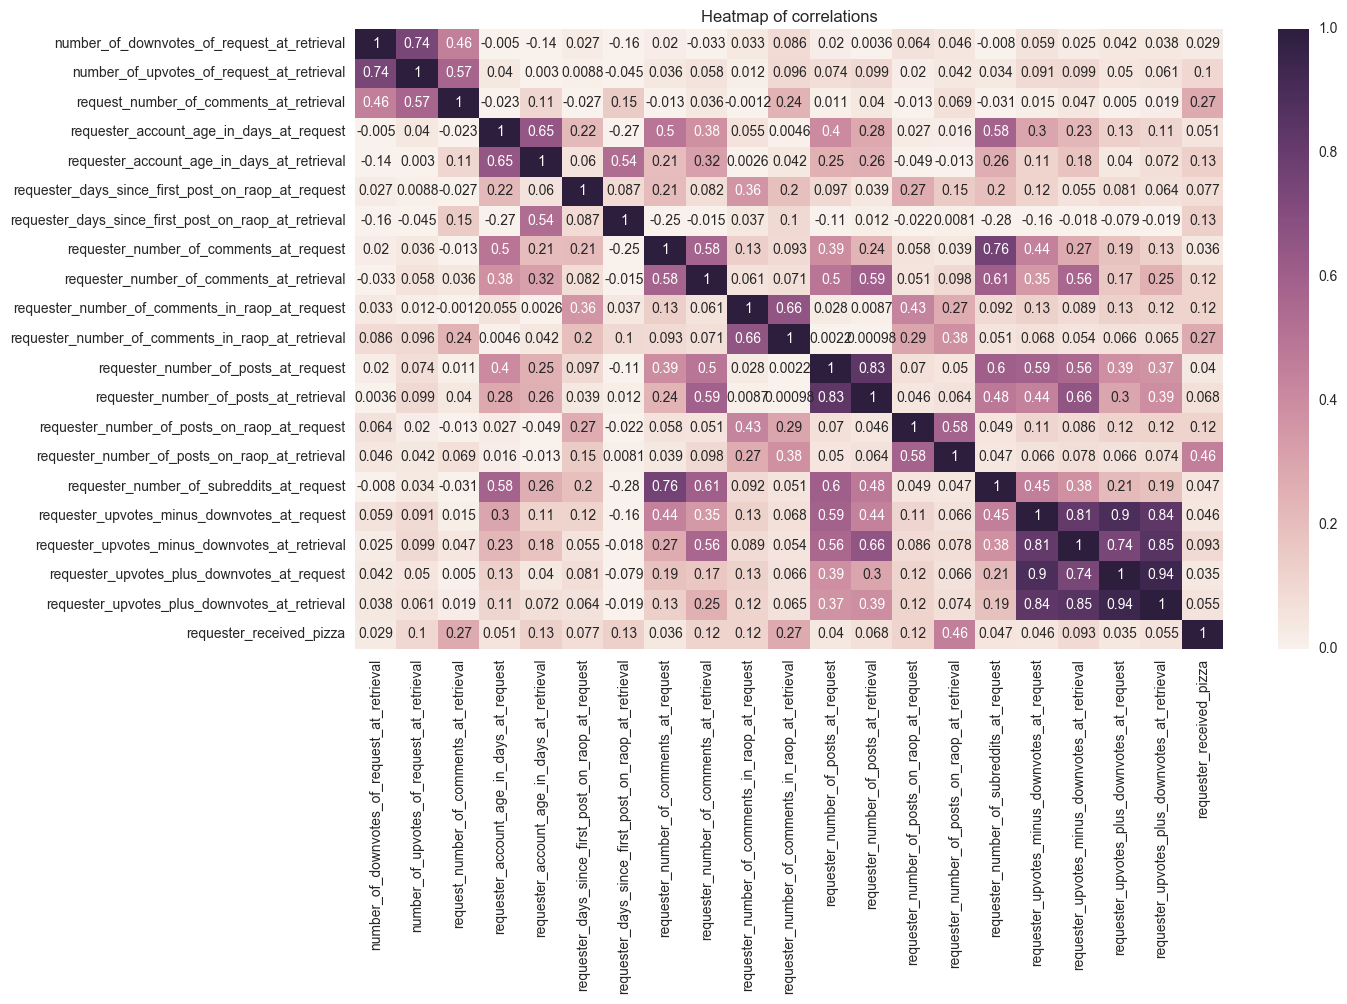

In [7]:
df_cont = df[cont_features]
correlations = df_cont.join(df[target]).corr()
plt.figure(figsize = FIG_SIZE)
plt.title("Heatmap of correlations")
_ = sns.heatmap(correlations, vmin=0, vmax=1, annot=True)


This is an interesting and intuitive result. Many of the continuous fields show strong correlation with each other. For example the number of subreddits that the requester is part of correlates highly with the number of comments made by the requester. This means that a PCA transformation could yield a dataset with fewer features and may allow classification of different types of users.

Looking at the `requester_received_pizza` column the correlation between each of the continuous features and the target can be observed. It does not seem like there are much correlation. The highest comes from the `requester_number_of_posts_on_raop_at_retrieval` at 0.46. It seems that, as postulated above, the continuous features would not be a great indicator of if a requester receives pizza or not.


## Heatmap for presentation
I'll trim down some of the features to make this look good in a slide

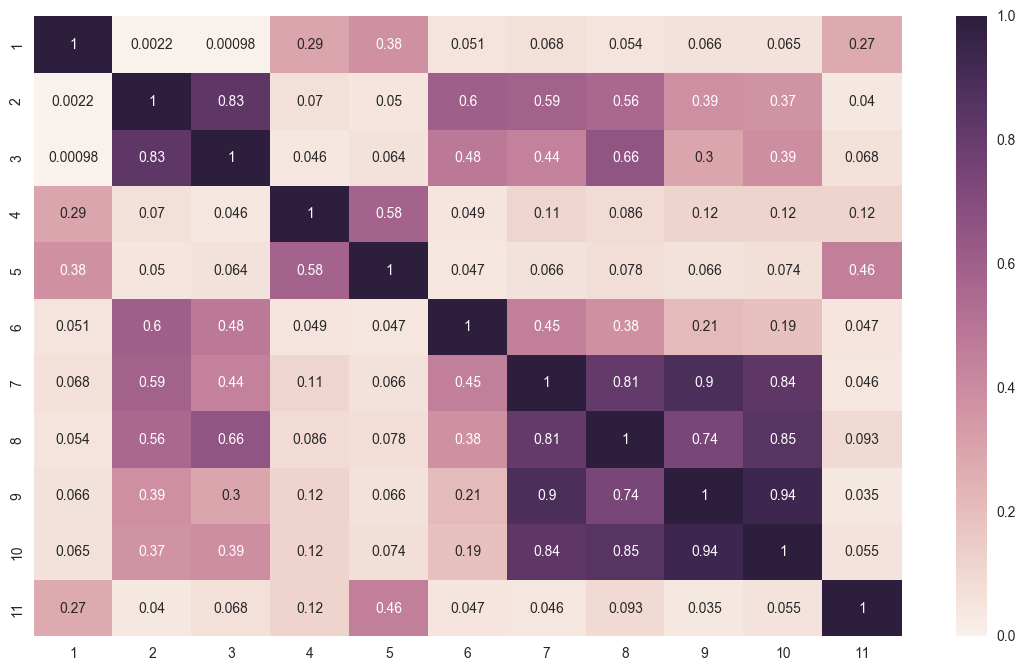

In [8]:
feats = ['1','2','3','4','5','6','7','8','9','10','11']
df_cont_small = df[cont_features[-10:]]
correlations_small = df_cont_small.join(df[target]).corr()
plt.figure(figsize = FIG_SIZE)
_ = sns.heatmap(correlations_small, vmin=0, vmax=1, annot=True, xticklabels=feats, yticklabels=feats)

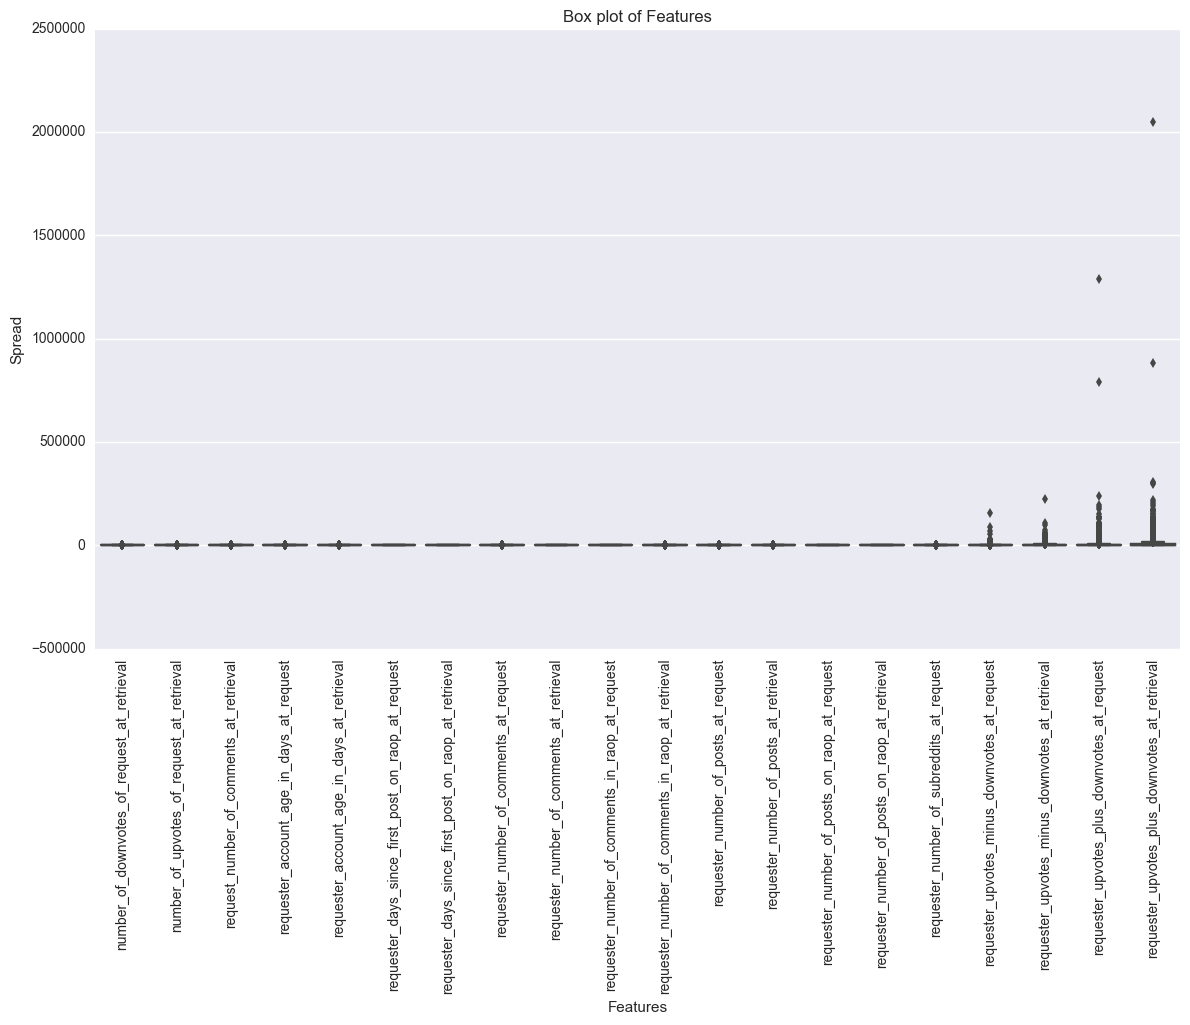

In [9]:
df_cont = df[cont_features]
plt.figure(figsize=FIG_SIZE)
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xlabel('Features')
plt.xticks(rotation='vertical')
display(sns.boxplot(df_cont[df_cont.columns]))

Uglllly. Lets see what scaling the features does. As a shameless plug, and for more information on the importance of scaling, refer to this [post](http://scikit-learn.org/dev/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py) that I wrote for the sklearn library.

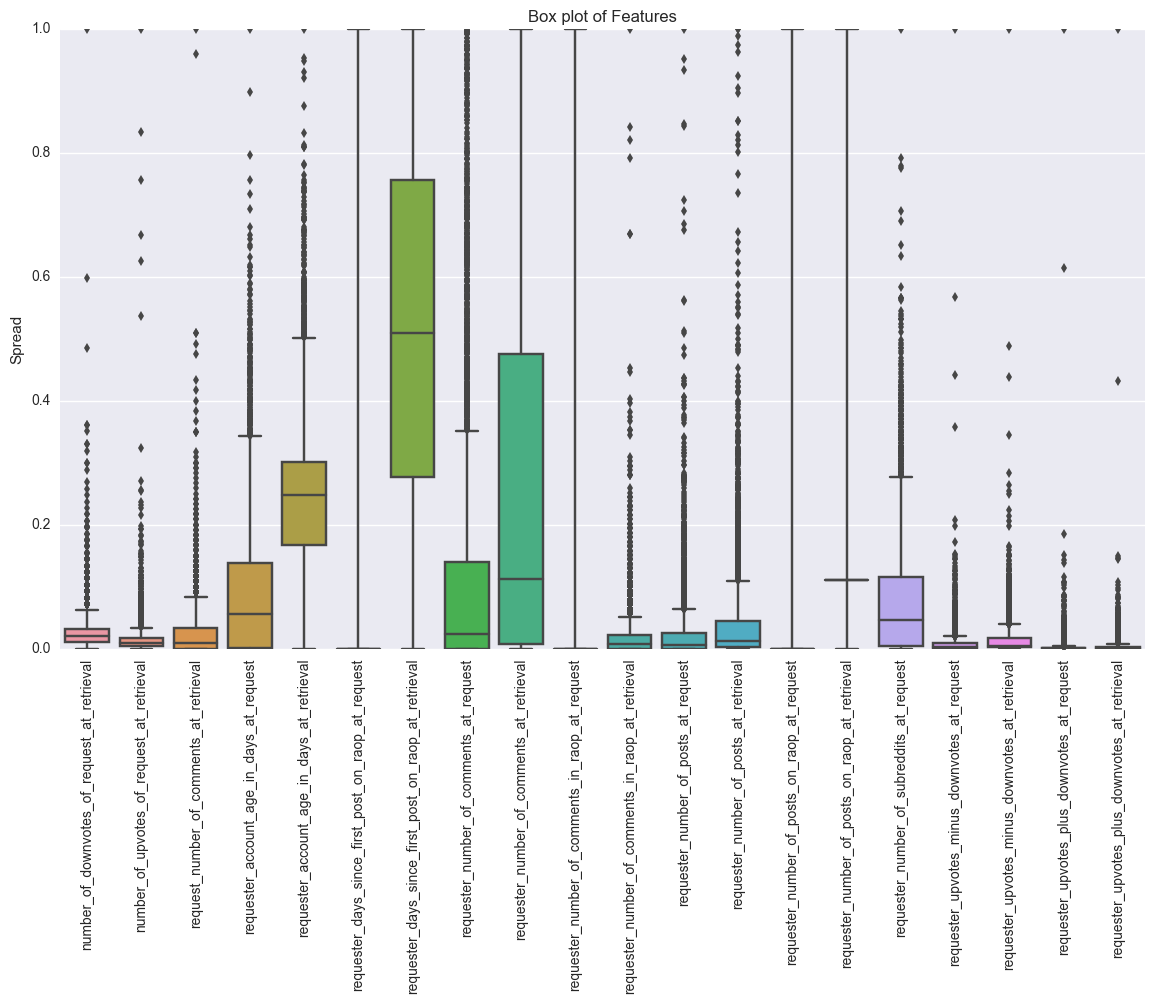

In [10]:
sc = MinMaxScaler()

df_cont = df[cont_features]
df_cont_scaled = pd.DataFrame(sc.fit_transform(df_cont), columns = df_cont.columns, )
plt.figure(figsize=FIG_SIZE)
plt.title('Box plot of Features')
plt.ylabel('Spread')
plt.xticks(rotation='vertical')
display(sns.boxplot(df_cont_scaled))

I'm not seeing anything here that I want to use for the presentation. Moving on.

# Text Features

As discussed in the research paper, there is a certain lexicon associated with different narratives for the request text. Maybe we can find a set of vocabulary that is common to all of the successful posts using kMeans clustering and TFIDF vectorization.

In [11]:
#combine all the text to one column.
df['text'] = df['request_title'].map(str) + ' ' + df['request_text']
df1 = df.copy(deep = True)

#remove punctuation
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))
def remove_punctuation(text):
    return text.translate(tbl)

df1['text'] = df1['text'].apply( lambda x: remove_punctuation(x))
df1['text'].head(4)

# TODO: stemming



0    Request Ontario Canada  On my 3rd of 5 days wi...
1    REQUEST Southern Arizona Tucson Hungry Family ...
2    Request Pizza for a broke college student Im s...
3    Request Unemployed and Sick of Rice Suffolk Co...
Name: text, dtype: object

In [12]:
# TODO: Use silouette sore to optimize amount of clusters.
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)

vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 2), 
                             stop_words='english')

In [13]:
tfidf_features = vectorizer.fit_transform(df1['text'])
vocab = vectorizer.get_feature_names()
sse_err = []
res = kmeans.fit(tfidf_features)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()

for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)
print(words)

['dont', 'broke', 'im', 'love pizza', 'week', 'really', 'college', 'tonight', 'pay', 'hungry', 'ive', 'request', 'just', 'like', 'thanks', 'money', 'college student', 'work', 'love', 'help', 'student', 'pizza', 'food', 'job', 'usa']


Interesting. There is overlap between this result an the lexicons of `Money` and `Student` that are put forward by the  Altruistic Requests paper. Lets see if we can train a predictor using these words as features.

# Training a predictor

It will be interesting to see how the resulting features that we have found perform in a testing situation. Staying true to Altruistic Requests, lets use a `LogisticRegressor` with a AUC_ROC scoring. In a more in-depth analysis, other algorithms such as `RandomForests` or convolutional neural nets would also be investigated.

First we'll define a helper function. The helper function takes in training and testing features and labels, makes a grid search to find the optimum parameters for a `LogisticRegression`, uses the fitted regressor to estimate test labels, and plot a AUC_ROC curve with the score shown. For comparison purposes, it also shows timing of the fitting function.  

In [14]:
# A helper function for testing feature sets

def train_test_plot(X_train, X_test, y_train, y_test):
    # Grid search to find best parameteres
    gs = grid_search.GridSearchCV(
        estimator=LogisticRegression(),
        param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
        cv=cross_validation.StratifiedKFold(y_train,n_folds=10),
        scoring='roc_auc'
    )
    
    start = time.clock()
    gs.fit(X_train, y_train)
    end = time.clock()
    print ("Grid Search Fitting time : %s seconds" % (end - start))
    
    print('Best Estimator:', gs.best_estimator_)
    
    probas = gs.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)


    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return

Next we will select the TFIDF features that are part of the vocabulary that we found using kmeans clustering, make a train, test split, then use our helper function to observe the results.

Grid Search Fitting time : 4.864972999999999 seconds
Best Estimator: LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


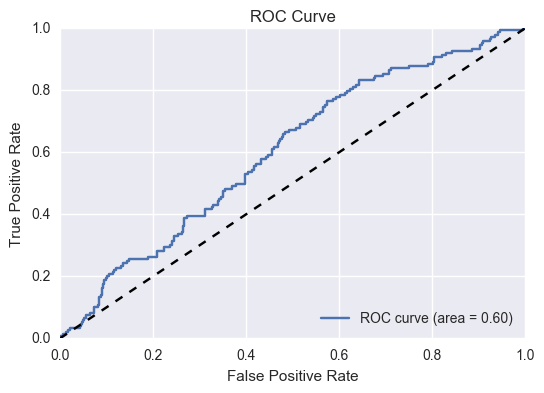

In [13]:
#add top words to X features.
X = tfidf_features[:,[np.argwhere(vocab==i)[0][0] for i in words]]
y = df['requester_received_pizza']

# Split up the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Pass to Helper Function
train_test_plot(X_train, X_test, y_train, y_test)


These results aren't that great, but they are better than just randomly guessing. . They do not meet the benchmarks set by the paper. Lets see if we can improve them!



# Adding features together

Before, we identified a continuous features that had a 0.46, ad 0.26 correlation with the `requester_recieved_pizza` target. Let's see the effect of adding these into the feature set.

In [14]:
# Add new features to feature set.
new_feat_list = ['requester_number_of_comments_in_raop_at_retrieval',
                 'requester_number_of_posts_on_raop_at_retrieval']

new_feat = df[new_feat_list]
new_X = pd.DataFrame(X.todense()).join(new_feat)


It's also important to scale these features. As the new added feature `requester_number_of_posts_on_raop_at_retrieval` is not a value between [1,0] like the tfidf features, not scaling could cause the learning algorithm to disproportionately find important in the new feature. 

As a shameless plug, and for more information on this topic, refer to this [post](http://scikit-learn.org/dev/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py) that I wrote for the sklearn library.

Grid Search Fitting time : 19.115107000000002 seconds
Best Estimator: LogisticRegression(C=100000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


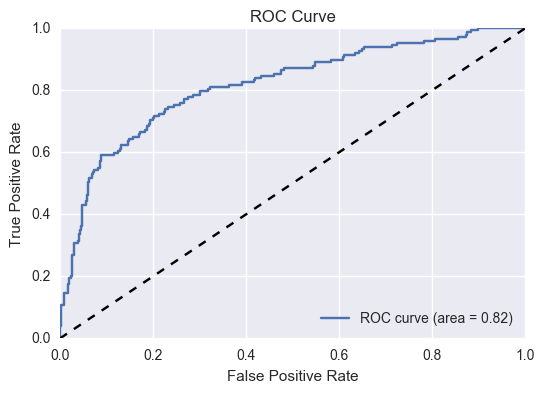

In [15]:
# Create scaler
scaler = StandardScaler()

# Scale the features
new_X_scaled = scaler.fit_transform(new_X)

# Split up the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(new_X_scaled, y, test_size=0.10, random_state=42)

# Pass to helper function
train_test_plot(X_train_scaled, X_test_scaled, y_train, y_test)


Bingo!! This is awesome. I think I am on to something. Although this improved on the paper's best results of 0.672 significantly, it is important not get too excited. The goal of Altruistic Requests was to make general statements about how to formulate a request in order to maximize return, and not to make the most accurate predictor.

As a side note, converting the features to a dense matrix as opposed to a sparse matrix, greatly increased the fitting time.

Just to see what would happen lets include all of the continuous variables.

Grid Search Fitting time : 80.518045 seconds
Best Estimator: LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


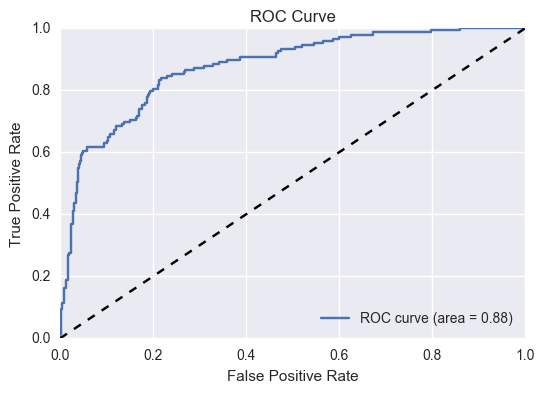

In [16]:
# Add all features to feature set.
new_feat_list = cont_features
new_feat = df[new_feat_list]
new_X = pd.DataFrame(X.todense()).join(new_feat)


# Create scaler
scaler = StandardScaler()

# Scale the features
new_X_scaled = scaler.fit_transform(new_X)

# Split up the data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(new_X_scaled, y, test_size=0.10, random_state=42)

# Pass to helper function
train_test_plot(X_train_scaled, X_test_scaled, y_train, y_test)

This change is not as drastic as the addition of the two most correlated continuous variables. Fitting the data also took almost 4 times as long. 

# Future recommendations

As this was just an initial analysis with a limited time frame, there is plenty of room for improvement on the results. I conclude this analysis with the following recommendations:

1. Add different features used in the paper Altruistic Requests (such as presence of "Evidence" such as links to photos, key phrases such as "pay it forward", or length of post). This will most definitely increase accuracy of the predictor.
2. Investigate uses of other algorithms. A good candidate is a convolutional neural network ('CNN'). In a recent paper [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882), Kim Yoon shows that CNN's are state of the art for many sentence classification tasks. 
3. Try adding features that count how many words are in the topical lexicons provided by Altruistic Requests. The words that were found using kmeans greatly reduced the dimensionality of the data (therefore increasing prediction and fitting speed), however, it likely came at the cost of accuracy. This was not investigated as training was taking too long on my comuter and I grew impatient.


# For Fun
Lets just check the result of including the word 'dog' in the post.

In [15]:
import re
def dog_test(inputstring):
    x = inputstring
    a = re.search("dog", x)
    if a:
        return 1
    else:
        return 0
    
df['dog?'] = df['text'].apply(lambda j: dog_test(j))

print('Amount of posts containing the word dog:', sum(df['dog?']))

Amount of posts containing the word dog: 149


In [16]:
print('Amount of posts containing Pizza:', sum(df['requester_received_pizza']))

Amount of posts containing Pizza: 1397


In [17]:
count = 0
for index, row in df.iterrows():
    if row['dog?'] == 1 and row['requester_received_pizza'] == 1:
        count += 1
        
print(count)
        


53


53/149 posts mentioning dogs were successful.